In [14]:
import os
from datetime import datetime
import sys
sys.path.append("../scripts/twitter")
import utils as ut

from searchTwitter import TwitterDataFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re
from math import ceil

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

from imblearn import over_sampling
from imblearn import under_sampling

np.random.seed(23)

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

sf_df_raw = concat_data('../data/san_francisco/')

# Turn into a TwitterDataFrame and zoom in on san francisco
sf_df_raw = TwitterDataFrame(sf_df_raw)

sf_df_raw.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_17100/3815770650.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [41]:
sf_df_raw = sf_df_raw.dropna().reset_index(drop=True)

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)
sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
439249,1002338864273346561,1637084264,mines the 86 for MBTA and the 33 for MUNI,{'place_id': '5a110d312052166f'},2018-05-31 23:59:42,37.708075,-122.514926,2018-05-31
439250,1002338849979187201,2276720725,If you don’t need work over the summer conside...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:39,37.708075,-122.514926,2018-05-31
439251,1002338749919870976,391204136,@varadhjain 1. Practice 2. Observe those who a...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:15,37.708075,-122.514926,2018-05-31
439252,1002338701127573504,111136252,I heard one of the coldest things in a long ti...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:03,37.708075,-122.514926,2018-05-31
439253,1002338641505443841,783713395,@realDonaldTrump Talking about being treated u...,{'place_id': 'a769d8f00b12878d'},2018-05-31 23:58:49,37.565624,-122.515276,2018-05-31


In [42]:
sf_df = sf_df.group_by_days_and_batch(100)

sf_df.shape

(18136, 2)

In [ ]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  8156
Per day : 22.345205479452055


Text(0.5, 0, 'Date')

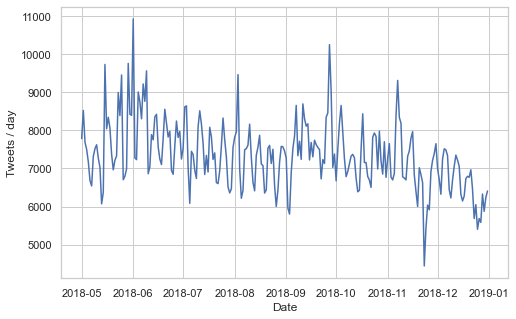

In [17]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(TwitterDataFrame(sf_df).count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

In [43]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

# Subset just SF country and extract dates
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_17100/2893133138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


In [44]:
sf_mrg = pd.merge(left=sf_df, right=sf_aqi, left_on='date', right_on='Date', how='inner')

sf_mrg.head()

,date,text,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,2018-05-01,@FlowerInFaith @resister1313 @SethAbramson And...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
1,2018-05-01,@alicia_minshew @ginatognoni @AnyaLiesnik @sha...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
2,2018-05-01,@NYTSports @SteveKerr In 1991 I was released o...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
3,2018-05-01,Karma for me is literally having the dumbest s...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
4,2018-05-01,"the ""santa did you fuck my mom"" scene from its...",California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1


In [45]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words('english')

stemmer = SnowballStemmer('english')

def process_tweet(tweet):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return ' '.join(tokens)

sf_mrg['text'] = sf_mrg['text'].apply(process_tweet)

In [46]:
sf_mrg.to_csv("../data/sf_cleaned/sf_cleaned.csv")

OSError: Cannot save file into a non-existent directory: '..\data\sf_cleaned'

In [47]:
train_df, test_df = train_test_split(sf_mrg, test_size=0.2, random_state=23)

In [48]:
vocab_size = 100000

emb_size = 100 # glove vectors are 100 dim

tweet_len = 5000 # tweets are all standardized to 40 words long

In [64]:
tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token='?')
tokenizer.fit_on_texts(train_df['text'])

word_index = tokenizer.word_index

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=tweet_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=tweet_len)

X_train.shape, X_test.shape, len(word_index)

((14508, 5000), (3628, 5000), 566364)

In [65]:
enc = OneHotEncoder().fit(train_df['Category'].to_numpy().reshape((-1, 1)))
y_train = enc.transform(train_df['Category'].to_numpy().reshape((-1, 1))).todense()
y_test = enc.transform(test_df['Category'].to_numpy().reshape((-1, 1))).todense()

y_train.shape, y_test.shape

((14508, 5), (3628, 5))

In [66]:
X_train, y_train = over_sampling.RandomOverSampler('not majority').fit_resample(X_train, y_train)
#X_train, y_train = under_sampling.RandomUnderSampler('majority').fit_resample(X_train, y_train)

C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
y_train.sum(axis=0)

array([11334, 11334, 11334, 11334, 11334])

In [68]:
# https://nlp.stanford.edu/projects/glove/
# a function to load vector model as dictionary
def load_glove_model(File):
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

glove = load_glove_model('../data/glove.twitter.27B.100d.txt')

1193514 words loaded


In [69]:
# Generate embedding layer for ml model
embedding_matrix = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
  if i >= vocab_size:
    break
  embedding_vector = glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [78]:
input = keras.layers.Input(shape=(tweet_len,), dtype='int32')
embed_layer = keras.layers.Embedding(vocab_size, emb_size, weights=[embedding_matrix], input_length=tweet_len, trainable=False)(input)
embed_layer = keras.layers.SpatialDropout1D(0.1)(embed_layer)
embed_layer = keras.layers.BatchNormalization()(embed_layer)

layers = []
for kernel_size in [3, 5]:
    temp = keras.layers.Conv1D(64, kernel_size, padding='same', kernel_initializer='he_uniform')(embed_layer)
    temp = keras.layers.BatchNormalization()(temp)
    layers.append(temp)

x = keras.layers.add(layers)
# x = keras.layers.Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(embed_layer)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(5, activation='softmax')(x)

cnn_model = keras.Model(input, output)
cnn_model.summary()

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5000, 100)    10000000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 5000, 100)    0           embedding_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 5000, 100)    400         spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [79]:
history = cnn_model.fit(X_train, y_train, batch_size=512, epochs=1, validation_data=(X_test, y_test), callbacks=callbacks)
#cnn_model = keras.models.load_model('../data/models/final_model.h5')

 84/111 [=====================>........] - ETA: 15:41 - loss: 1.4084 - accuracy: 0.3852

KeyboardInterrupt: 

In [72]:
cnn_model.save('../data/models/model_batch_resample.h5')

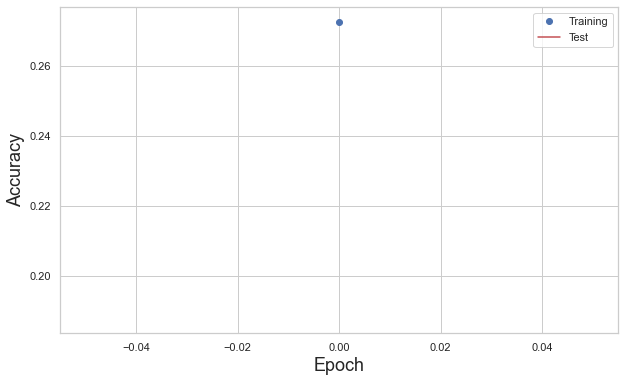

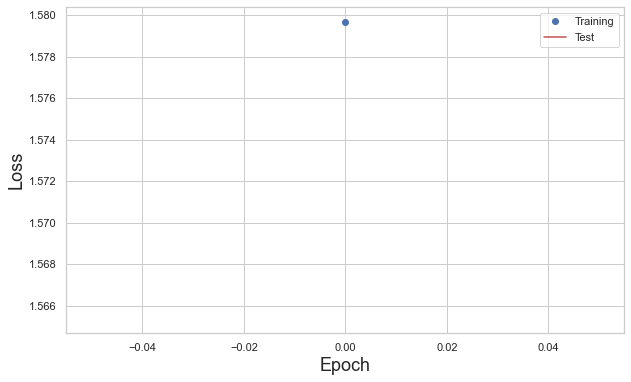

In [73]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_range = range(len(accuracy))

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, accuracy, 'bo', label='Training')
plt.plot(epoch_range, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, loss, 'bo', label='Training')
plt.plot(epoch_range, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

In [74]:
y_pred = cnn_model.predict(X_test)

In [75]:
y_test_ = np.argmax(y_test, axis = 1)
y_pred_ = np.argmax(y_pred, axis = 1)


accuracy_score(y_test_, y_pred_), balanced_accuracy_score(y_test_, y_pred_)

(0.18770672546857772, 0.3719006145066571)

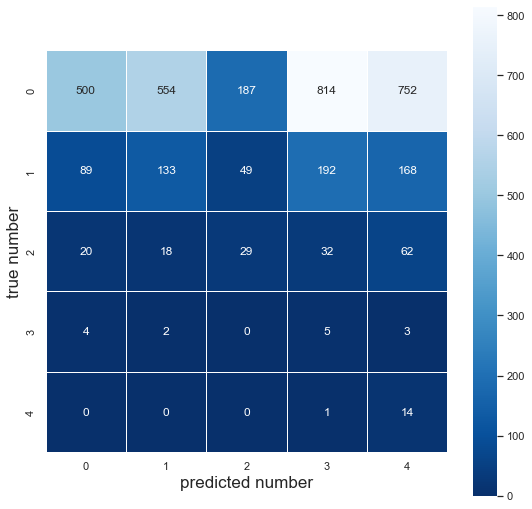

In [76]:
cm1 = confusion_matrix(y_test_, y_pred_)

plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true number', size=17)
plt.xlabel('predicted number', size=17)
plt.show()

